In [96]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA, FastICA
import scipy.cluster.hierarchy as sch

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ARDRegression, HuberRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.shape, test.shape

((4209, 378), (4209, 377))

In [3]:
train_id = train['ID'].astype(str)
train_labels = train['y'].to_frame()
train.drop(['ID', 'y'], axis=1, inplace=True)

test_id = test['ID'].astype(str)
test.drop(['ID'], axis=1, inplace=True)

df_all = pd.concat([train, test], ignore_index=True)

In [5]:
df_all.dtypes.value_counts()

int64     368
object      8
dtype: int64

In [6]:
(df_all[[col for col in df_all.columns if df_all[col].dtype == 'int64']].nunique() > 2).value_counts()

False    368
dtype: int64

This means that all the columns with dtype int64 are binary.

In [9]:
(df_all[[col for col in df_all.columns if df_all[col].dtype == 'object']]).nunique()

X0    53
X1    27
X2    50
X3     7
X4     4
X5    33
X6    12
X8    25
dtype: int64

In [10]:
cat_cols = [col for col in df_all.columns if df_all[col].dtype == 'object']
categorical_df = df_all[cat_cols]
binary_df = df_all.drop(cat_cols, axis=1)

Applying One Hot Encoding to the categorical columns.

In [11]:
ohe = OneHotEncoder()
ohe_features = ohe.fit_transform(categorical_df).toarray()
ohe_feature_names = ohe.get_feature_names_out(categorical_df.columns)
ohe_df = pd.DataFrame(ohe_features, columns = ohe_feature_names)

df_all = pd.concat([df_all, ohe_df], axis=1)
binary_df = pd.concat([binary_df, ohe_df], axis=1)

binary_df_train = binary_df.iloc[:len(train), :]
binary_df_test = binary_df.iloc[len(train):, :]

# Principal Component Analysis (PCA)

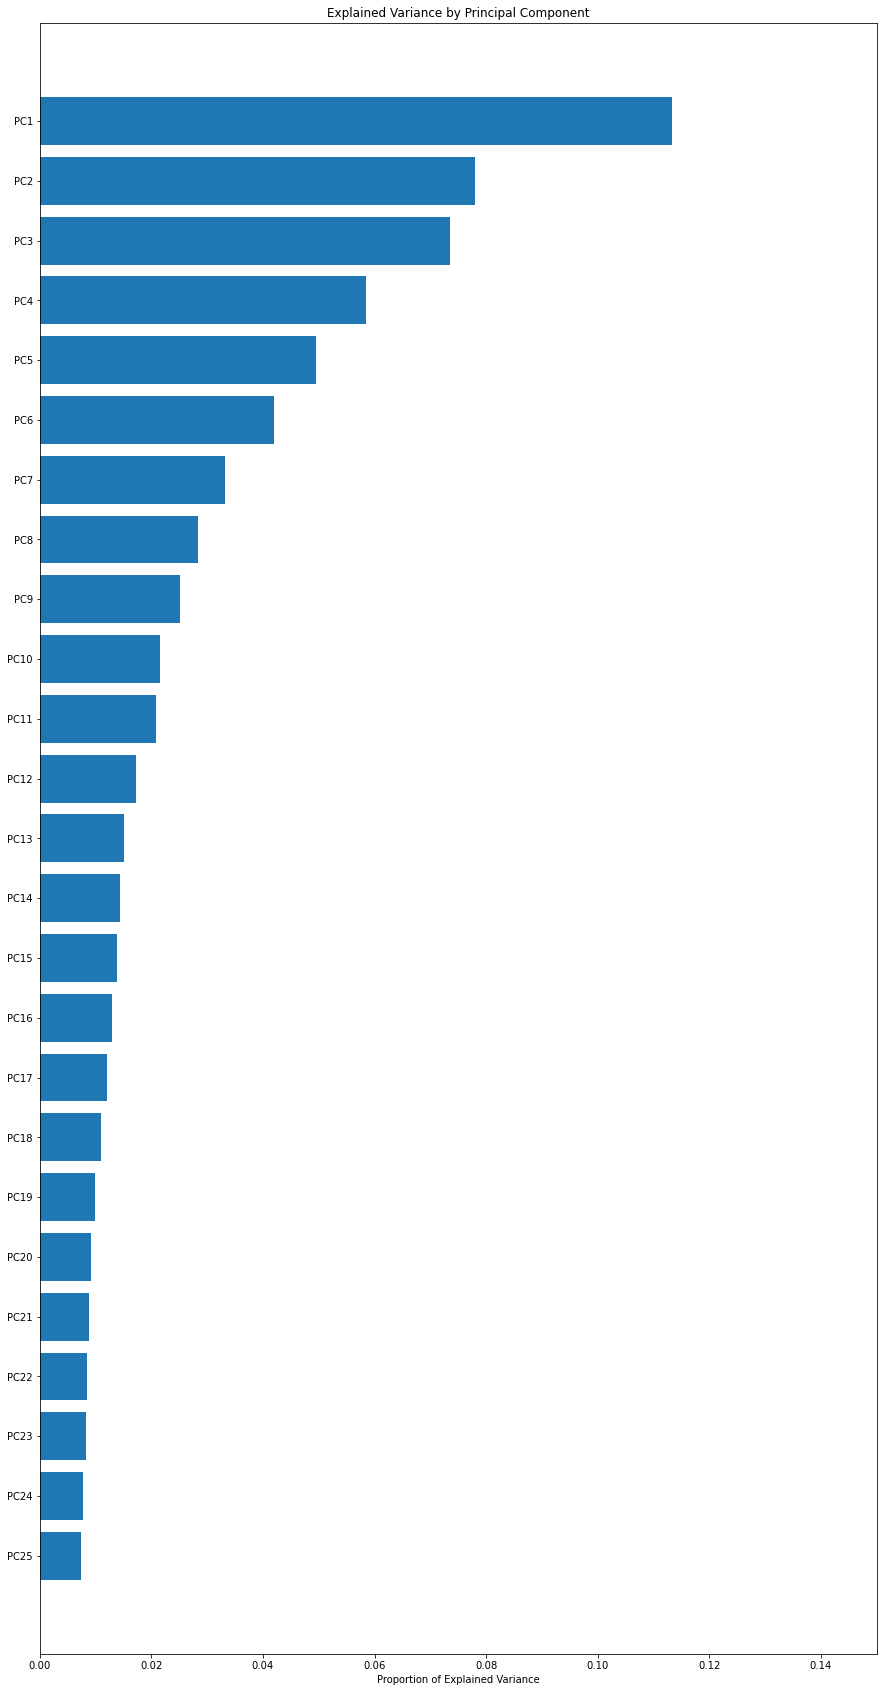

In [87]:
pca = PCA()
pca_features = pca.fit_transform(binary_df_train)

importance_pca = pca.explained_variance_ratio_
indices = np.argsort(importance_pca)
indices = indices[importance_pca[indices] > 0.007]

plt.figure(figsize=(15, 30))
plt.barh(range(len(indices)), importance_pca[indices], align='center')
plt.xlabel('Proportion of Explained Variance')
plt.title('Explained Variance by Principal Component')
plt.yticks(range(len(indices)), ['PC{}'.format(i+1) for i in indices])
plt.xlim(0, 0.15)
plt.show()

In [114]:
importance_pca[indices].sum()

0.6996202531635185

We are getting 25 features out of 579 that explain 70% of variance.

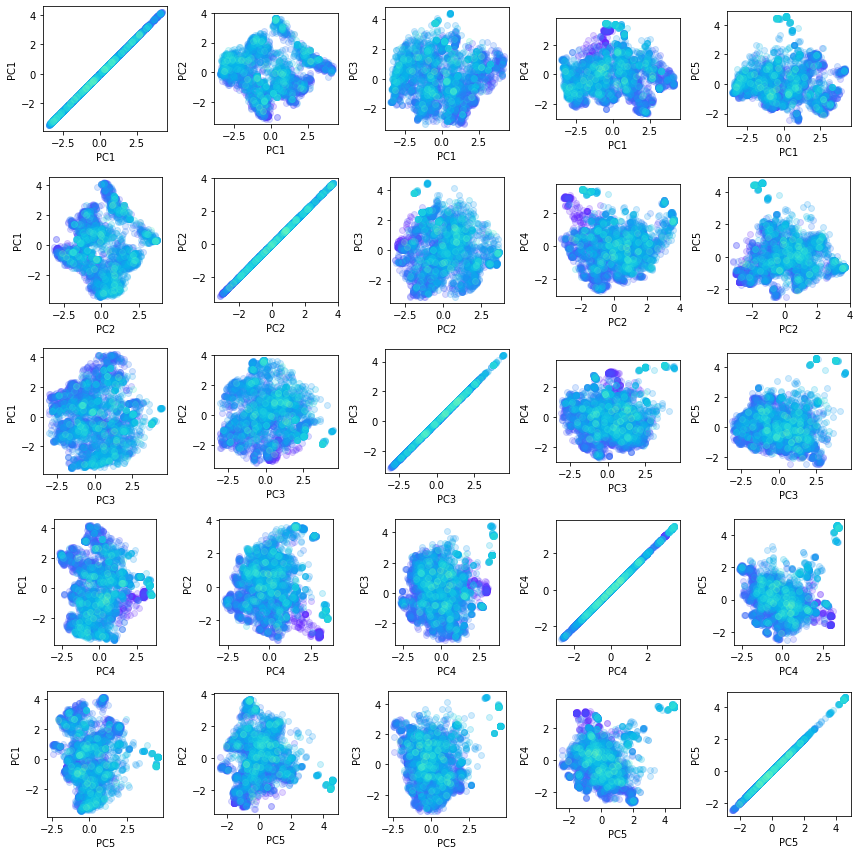

In [62]:
train_labels_arr = np.array(train_labels, dtype=np.float64)
train_labels_arr = train_labels_arr.ravel()

breaks = 20
colors = plt.cm.rainbow(np.linspace(0, 1, breaks))
target_binned = np.digitize(train_labels_arr, np.linspace(min(train_labels_arr), max(train_labels_arr), breaks))

plt.figure(figsize=(12, 12))
for i in range(5):  # Plot for the first five principal components
    for j in range(5):
        plt.subplot(5, 5, i * 5 + j + 1)
        for k in range(breaks):
            mask = target_binned == k
            plt.scatter(pca.transform(binary_df_train)[:, i][mask], pca.transform(binary_df_train)[:, j][mask], color=colors[k], alpha=0.2)
        plt.xlabel(f'PC{i+1}')
        plt.ylabel(f'PC{j+1}')
        plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

plt.show()

Now let's use these PCA features to create our model.

In [88]:
X = pca_features[:, indices]
y = np.array(train_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = y_train.ravel()
y_test = y_test.ravel()

results = {}

models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    # ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    CatBoostRegressor(),
    SVR(),
    KNeighborsRegressor()
    # MLPRegressor()
]

for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'R2': r2}

LinearRegression
Ridge
Lasso
DecisionTreeRegressor
RandomForestRegressor
GradientBoostingRegressor
XGBRegressor
CatBoostRegressor
Learning rate set to 0.0496
0:	learn: 12.5096727	total: 2.1ms	remaining: 2.1s
1:	learn: 12.3279361	total: 3.73ms	remaining: 1.86s
2:	learn: 12.1375937	total: 5.9ms	remaining: 1.96s
3:	learn: 11.9504767	total: 7.96ms	remaining: 1.98s
4:	learn: 11.7848930	total: 9.71ms	remaining: 1.93s
5:	learn: 11.6174564	total: 11.2ms	remaining: 1.85s
6:	learn: 11.4757100	total: 12.7ms	remaining: 1.8s
7:	learn: 11.3250618	total: 14.2ms	remaining: 1.76s
8:	learn: 11.1955891	total: 15.8ms	remaining: 1.74s
9:	learn: 11.0481236	total: 17.5ms	remaining: 1.73s
10:	learn: 10.9445211	total: 19.1ms	remaining: 1.72s
11:	learn: 10.8351337	total: 20.5ms	remaining: 1.68s
12:	learn: 10.7356692	total: 22.2ms	remaining: 1.69s
13:	learn: 10.6446386	total: 23.6ms	remaining: 1.66s
14:	learn: 10.5520160	total: 25.4ms	remaining: 1.67s
15:	learn: 10.4666438	total: 26.9ms	remaining: 1.65s
16:	lear

In [89]:
sorted_results = dict(sorted(results.items(), key=lambda item: item[1]['MSE']))
sorted_results

{'Ridge': {'MSE': 71.90033348087842, 'R2': 0.5380638524813316},
 'LinearRegression': {'MSE': 71.9008114867975, 'R2': 0.5380607814495009},
 'SVR': {'MSE': 74.93958303204501, 'R2': 0.5185376672601307},
 'GradientBoostingRegressor': {'MSE': 75.71818933373468,
  'R2': 0.5135353761993815},
 'CatBoostRegressor': {'MSE': 82.57670174647917, 'R2': 0.4694716751249668},
 'Lasso': {'MSE': 84.50189712919045, 'R2': 0.4571029238931399},
 'KNeighborsRegressor': {'MSE': 85.14954616627077, 'R2': 0.4529419904641925},
 'RandomForestRegressor': {'MSE': 88.05010770514973, 'R2': 0.4343068304024258},
 'XGBRegressor': {'MSE': 95.96157752808631, 'R2': 0.38347822204570037},
 'DecisionTreeRegressor': {'MSE': 195.77057454391002,
  'R2': -0.25776196888405933}}

<AxesSubplot:>

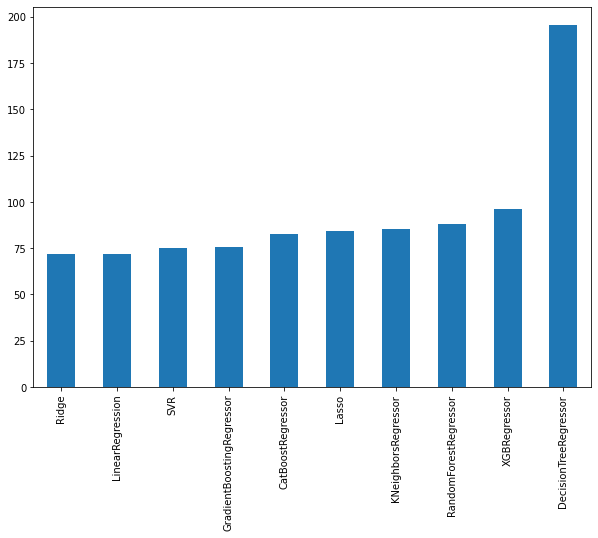

In [155]:
pd.DataFrame(sorted_results).T['MSE'].plot(kind = 'bar', figsize = (10,7))

# Independent Component Analysis (ICA)

In [90]:
n_ica_features = 12

ica_model = FastICA(n_components=n_ica_features, whiten=True)
ica_features = ica_model.fit_transform(binary_df_train)
ica_features = pd.DataFrame(ica_features, columns=[f"IC{i+1}" for i in range(n_ica_features)])

/Users/celestiq/tensorflow-ml/ml_env/lib/python3.8/site-packages/sklearn/decomposition/_fastica.py:654: FutureWarning: From version 1.3 whiten=True should be specified as whiten='arbitrary-variance' (its current behaviour). This behavior is deprecated in 1.1 and will raise ValueError in 1.3.
  return self._fit(X, compute_sources=True)


In [93]:
X_ica = ica_features
y_ica = np.array(train_labels)

X_train_ica, X_test_ica, y_train_ica, y_test_ica = train_test_split(X_ica, y_ica, test_size=0.2, random_state=42)
y_train_ica = y_train_ica.ravel()
y_test_ica = y_test_ica.ravel()

results_ica = {}

models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    CatBoostRegressor(),
    SVR(),
    KNeighborsRegressor()
]

for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    model.fit(X_train_ica, y_train_ica)
    y_pred_ica = model.predict(X_test_ica)
    mse = mean_squared_error(y_test_ica, y_pred_ica)
    r2 = r2_score(y_test_ica, y_pred_ica)
    results_ica[model_name] = {'MSE': mse, 'R2': r2}

LinearRegression
Ridge
Lasso
DecisionTreeRegressor
RandomForestRegressor
GradientBoostingRegressor
XGBRegressor
CatBoostRegressor
Learning rate set to 0.0496
0:	learn: 12.4261290	total: 1.47ms	remaining: 1.47s
1:	learn: 12.1700897	total: 2.8ms	remaining: 1.4s
2:	learn: 11.9294496	total: 4.04ms	remaining: 1.34s
3:	learn: 11.6869995	total: 5.12ms	remaining: 1.27s
4:	learn: 11.4670197	total: 6.31ms	remaining: 1.25s
5:	learn: 11.2833152	total: 7.41ms	remaining: 1.23s
6:	learn: 11.0889888	total: 8.36ms	remaining: 1.19s
7:	learn: 10.9256140	total: 9.25ms	remaining: 1.15s
8:	learn: 10.7592144	total: 10.3ms	remaining: 1.13s
9:	learn: 10.6086459	total: 11.4ms	remaining: 1.13s
10:	learn: 10.4642228	total: 12.4ms	remaining: 1.11s
11:	learn: 10.3319570	total: 13.5ms	remaining: 1.11s
12:	learn: 10.2058804	total: 14.4ms	remaining: 1.1s
13:	learn: 10.0887542	total: 15.4ms	remaining: 1.08s
14:	learn: 9.9865622	total: 16.3ms	remaining: 1.07s
15:	learn: 9.8829142	total: 17.5ms	remaining: 1.07s
16:	learn

In [95]:
sorted_results_ica = dict(sorted(results_ica.items(), key=lambda item: item[1]['R2']))
sorted_results_ica

{'DecisionTreeRegressor': {'MSE': 180.78809570302187,
  'R2': -0.1615044382026416},
 'Lasso': {'MSE': 155.6567231718036, 'R2': -4.358194646236768e-05},
 'Ridge': {'MSE': 100.2156029759854, 'R2': 0.35614749864409756},
 'XGBRegressor': {'MSE': 93.46816152090935, 'R2': 0.3994976051104955},
 'KNeighborsRegressor': {'MSE': 84.03441800950118, 'R2': 0.4601063244775351},
 'RandomForestRegressor': {'MSE': 83.81409410532392,
  'R2': 0.46152183356594545},
 'CatBoostRegressor': {'MSE': 80.0848021332852, 'R2': 0.48548131585393806},
 'SVR': {'MSE': 76.91082874588477, 'R2': 0.5058730576988135},
 'GradientBoostingRegressor': {'MSE': 75.51751536826316,
  'R2': 0.5148246408526791},
 'LinearRegression': {'MSE': 75.1323515203392, 'R2': 0.5172991927144001}}

<AxesSubplot:>

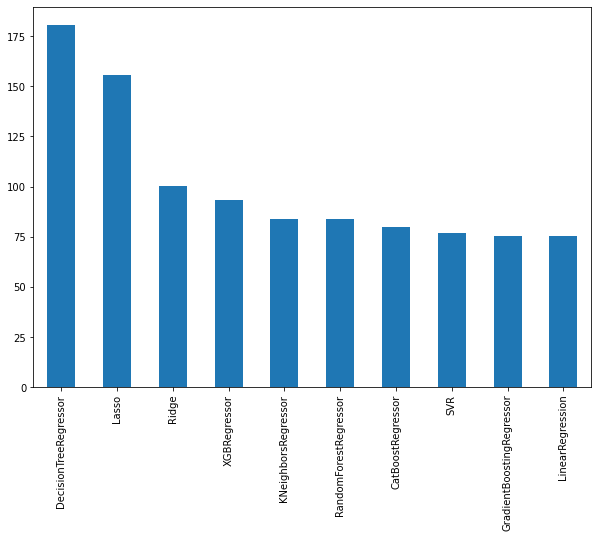

In [154]:
pd.DataFrame(sorted_results_ica).T['MSE'].plot(kind = 'bar', figsize = (10,7))

Parameter hypertuning for Ridge model

In [100]:
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 20.0, 50.0, 100.0],  # Regularization strength
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']  # Solvers for optimization
}

ridge = Ridge()

grid_search = GridSearchCV(ridge, param_grid, cv=20, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Mean Squared Error:", mse)
print("R2 Score: ", r2)

Best Parameters: {'alpha': 50.0, 'solver': 'lsqr'}
Mean Squared Error: 71.87539006789652
R2 Score:  0.5382241057589034


In [111]:
binary_df_train.shape, binary_df_test.shape

((4209, 579), (4209, 579))

In [121]:
ridge_final = Ridge(alpha = 50.0, solver = 'lsqr')
test_pca_features = pca.transform(binary_df_test)[:, indices]

ridge_final.fit(pca_features[:, indices], np.array(train_labels).ravel())
y_pred_final = ridge_final.predict(test_pca_features)

In [132]:
y_pred_series = pd.Series(y_pred_final, name='y')
result_df = pd.concat([test_id, y_pred_series], axis=1)
result_df.head()

,ID,y
0,1,77.321696
1,2,96.303561
2,3,83.632245
3,4,76.587966
4,5,110.567721


In [133]:
result_df.to_csv('results.csv', index=False)

In [135]:
result_df.shape

(4209, 2)